In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()
plt.rcParams['figure.figsize'] = (12, 6)

# Objetivo del cuadernillo

En este cuadernillo se quieren incluir 3 secciones principales:

1. Análisis Exploratorio de los datos para los egresos hospitalarios del INT entre 2001 a 2019.
2. Entrenamiento de modelos predictivos
3. Estimación de Egresos Hospitalarios a 2035

In [21]:
# Lee la base de datos
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")

# Crea columna de fecha en datetime
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# Elimina columnas redundantes
egresos_torax = egresos_torax.drop(
    columns=[
        "ANO_EGRESO",
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    ]
).sort_values("FECHA_EGRESO")

# Elimina el anio 2020, debido a que es anomalo (Pandemia COVID)
egresos_torax = egresos_torax.query("FECHA_EGRESO < '2020-01-01'")

# Elige la fecha como indice de los datos
egresos_torax = egresos_torax.set_index("FECHA_EGRESO")

Ahora, se quiere hacer un análisis del INT completo y también para los 45 diagnósticos más relevantes para el Hospital.

In [20]:
DIAGS_MAS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J91X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

In [33]:
# Obtiene metricas agregadas por dia (suma los egresos de todos los diags por dia)
df = egresos_torax.resample("D").sum()[["n_egresos"]]
df_relevantes = (
    egresos_torax[egresos_torax["DIAG1"].isin(DIAGS_MAS_RELEVANTES)]
    .resample("D")
    .sum()[["n_egresos"]]
)

## 1. Análisis Exploratorio de los Datos

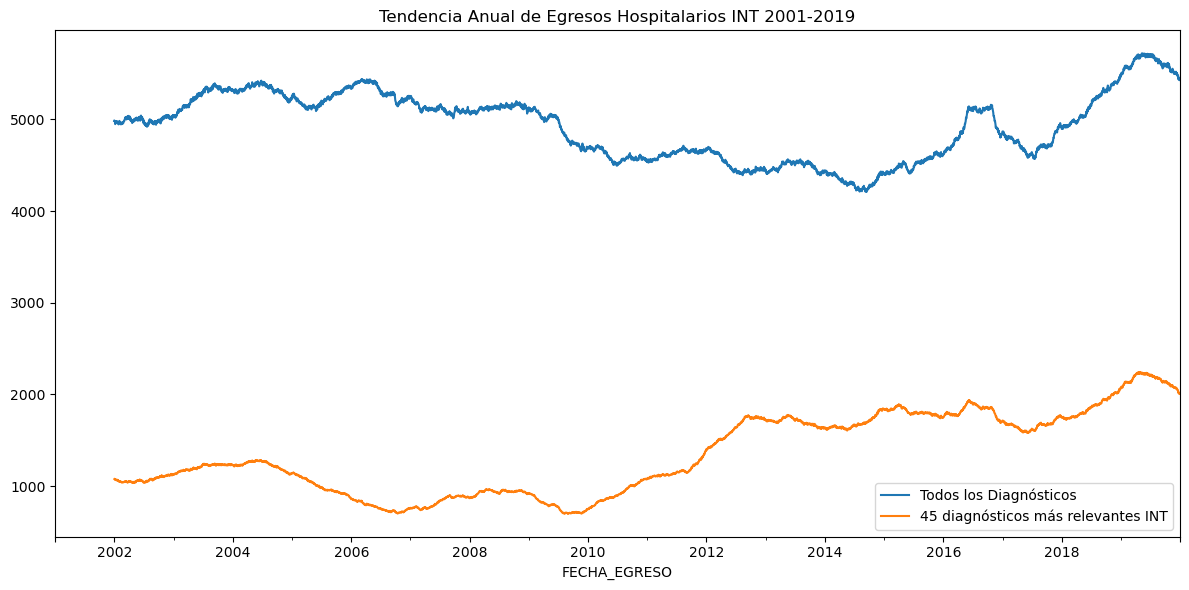

In [70]:
fig, axis = plt.subplots(1, 1, sharey=True)

ROLLING_AVERAGE = 365

df.rolling(ROLLING_AVERAGE).sum().plot(y="n_egresos", label="Todos los Diagnósticos", ax=axis)
df_relevantes.rolling(ROLLING_AVERAGE).sum().plot(
    y="n_egresos", label="45 diagnósticos más relevantes INT", ax=axis
)

plt.title("Tendencia Anual de Egresos Hospitalarios INT 2001-2019")
plt.tight_layout()
plt.legend()
plt.show()